In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand
plt.style.use('seaborn')

# Branch-and-Bound algorithm for 2-dimensional plane

In [11]:
class Disk:
    
    def __init__(self, x, y):
        self.center = (x, y)
        
    def contains(self, point):
        # True if the distance between the center and the given point <= 1
        return ((self.center[0] - point[0]) ** 2 + (self.center[1] - point[1]) ** 2) ** 0.5 <= 1
    
    def __repr__(self):
        return f"({self.center[0]}, {self.center[1]})"
    

d = Disk(0, 0)
print(d.contains((0.5, 0.5)))
print(d.contains((0.5, 4.5)))
print(d.contains((1, 0)))
print(d.contains((0, 1)))
print(d.contains((0, 1+0.000001)))

True
False
True
True
False


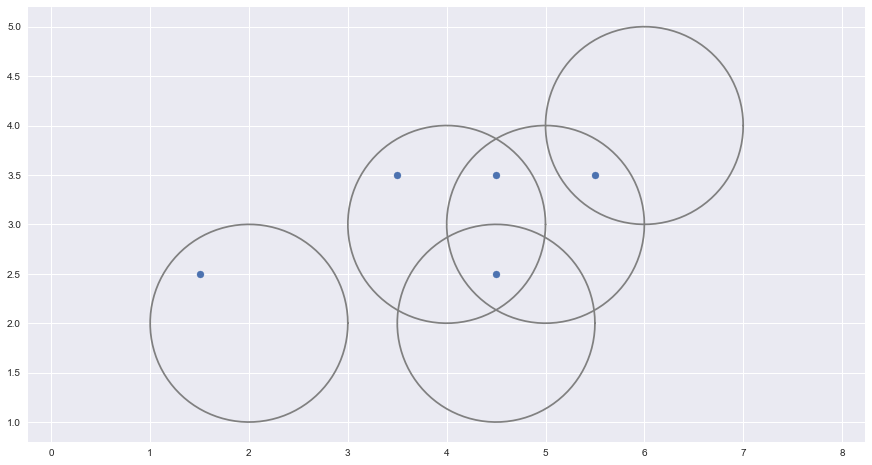

In [12]:
# Visualizing points and disks
def show(P, Q, figsize=(15, 8), colors=None):
    plt.figure(figsize=figsize)
    plt.axis('equal')
    
    # Plot points
    points = np.array(P).reshape((len(P), 2))
    plt.scatter(points[:,0], points[:,1])
    
    # Plot disks
    i = 0
    for disk in Q:
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(1.0)
        x1 = r*np.cos(theta) + disk.center[0]
        x2 = r*np.sin(theta) + disk.center[1]
        plt.plot(x1, x2, color='grey' if colors is None else colors[i])
    
        i+=1
    
        
P = [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5)]
Q = [Disk(2, 2), Disk(4, 3), Disk(4.5, 2), Disk(5, 3), Disk(6, 4)]
show(P, Q)

[(2, 2), (4.5, 2), (4, 3), (0, 0), (6, 4), (5, 3)]
Interation 0
[(0, 0)]
Current node is  (0, 0) trying to add (2, 2) to the solution
Best solution is None
Interation 1
[(1, 3)]
Current node is  (1, 3) trying to add (4.5, 2) to the solution
Best solution is None
Interation 2
[(2, 4), (1, 3)]
Current node is  (1, 3) trying to add (4, 3) to the solution
Best solution is None
Interation 3
[(2, 4), (2, 6)]
Current node is  (2, 4) trying to add (4, 3) to the solution
Best solution is None
Interation 4
[(2, 6), (3, 6)]
Current node is  (2, 6) trying to add (0, 0) to the solution
Best solution is None
Interation 5
[(3, 6), (3, 6), (2, 6)]
Current node is  (3, 6) trying to add (0, 0) to the solution
Best solution is None
Interation 6
[(3, 6), (2, 6), (4, 6), (3, 6)]
Current node is  (3, 6) trying to add (6, 4) to the solution
Best solution is (4, 8)
Interation 7
[(2, 6), (4, 6), (3, 6), (3, 6)]
Current node is  (2, 6) trying to add (6, 4) to the solution
Best solution is (3, 8)
Interation 8
[(

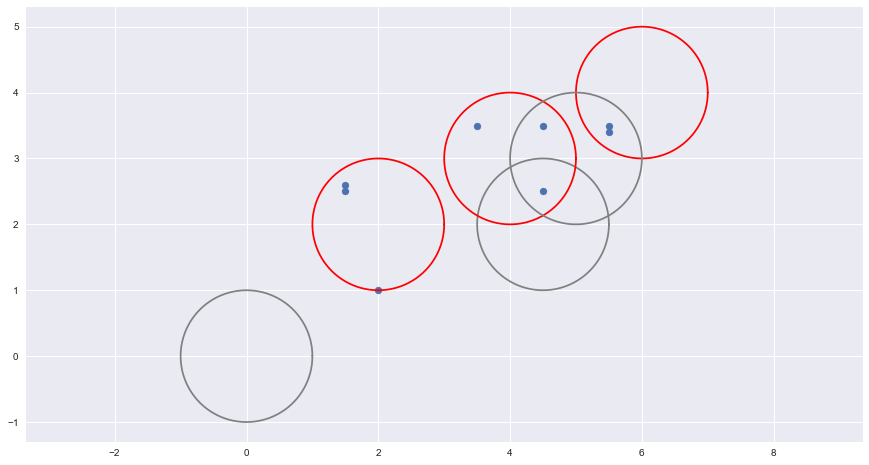

In [133]:
class BBTree:
    
    def __init__(self, P, Q, solution=None, nb_covered_points=0):
        self.solution = solution
        self.nb_covered_points = nb_covered_points
        self.P = P
        self.Q = Q
        self.h_value = self.heuristic()
        self.children = []
        
    def set_parent(self, parent):
        self.parent = parent
        
    def add_child(self, child):
        self.children.append(child)
    
    def heuristic(self):
        return self.nb_covered_points  # Number of covered points
    
    def is_realizable(self, best_score):
        # Check if there is a point that does not belong to any disk
        for point in self.P:
            outlier = True
            for disk in self.Q:
                if disk.contains(point):
                    outlier = False
                    break
            if outlier:
                return False
        # Cannot be realizable if no disk is left nor the current solution size is too high
        return len(self.Q) > 0 and best_score > len(self.solution)
    
    def __repr__(self):
        return f'({len(self.solution)}, {self.h_value})'
    
    def split(self):
        # Split in order of P
        # Check leaf condition
        if len(self.Q) == 0 or len(self.P) == 0:
            print("Leaf cannot be split")
            return None
        
        else:
            current_disk = self.Q[0]
            remaining_points = [point for point in self.P if not current_disk.contains(point)]
            nb_covered_points = self.nb_covered_points + len(self.P) - len(remaining_points)
            # Disk is added to the solution
            left_child = BBTree(remaining_points, self.Q[1:], solution=self.solution+[current_disk], nb_covered_points=nb_covered_points) 
            # Disk not added
            right_child = BBTree(self.P, self.Q[1:], solution=self.solution, nb_covered_points=self.nb_covered_points)  
            return left_child, right_child
            
            
            
def dudc_branch_and_bound(P, Q):
    root = BBTree(P, Q, solution=[])
    to_visit = [root]
    best_solution_size, best_solution = len(Q)+1, None  # Best solution's size is upper bounded
    tree_to_develop = None
    
    i = 0
    while len(to_visit) != 0:
        print("Interation", i)
        i += 1
        print(to_visit)
        
        # Select the best realizable node
        tree_to_develop = to_visit[0]
        for tree in to_visit:
            if tree.h_value < tree_to_develop.h_value:
                tree_to_develop = tree
        print("Current node is ", tree_to_develop, "trying to add", tree_to_develop.Q[0], 'to the solution')
        to_visit.remove(tree_to_develop)
        
        # Find children
        children = tree_to_develop.split()
        if children is not None:   
            for child in children:
                tree_to_develop.add_child(child)
                
                child_is_solution = all(any(disk.contains(point) for disk in child.solution) for point in P)
                if child.is_realizable(best_solution_size) and not child_is_solution:
                    to_visit.append(child)
                elif child_is_solution and len(child.solution) < best_solution_size:
                    best_solution_size = len(child.solution)
                    best_solution = child
            
        print(f"Best solution is {best_solution}")
    
    print("Returning", best_solution)
    return best_solution, root


P = [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5), (5.5, 3.4), (1.5, 2.6), (2, 1)]
Q = [Disk(0, 0), Disk(2, 2), Disk(4, 3), Disk(4.5, 2), Disk(5, 3), Disk(6, 4)]
rand.shuffle(Q)
print(Q)
sol_node, root = dudc_branch_and_bound(P, Q)

if sol_node is not None:
    colors = ['red' if disk in sol_node.solution else 'grey' for disk in Q]
    show(P, Q, colors=colors)


                              /-(5, 8)
                        /(4, 6)
                       |      \-(4, 6)
                  /(3, 6)
                 |     |      /-(4, 8)
            /(2, 4)     \(3, 6)
           |     |            \-(3, 6)
           |     |
           |      \-(2, 4)
           |
           |                  /-(4, 8)
      /(1, 3)           /(3, 6)
     |     |           |     |      /-(4, 8)
     |     |           |      \(3, 6)
     |     |      /(2, 6)           \-(3, 6)
     |     |     |     |
     |     |     |     |      /-(3, 8)
-(0, 0)    |     |      \(2, 6)
     |      \(1, 3)          |      /-(3, 8)
     |           |            \(2, 6)
     |           |                  \-(2, 6)
     |           |
     |            \-(1, 3)
     |
      \-(0, 0)


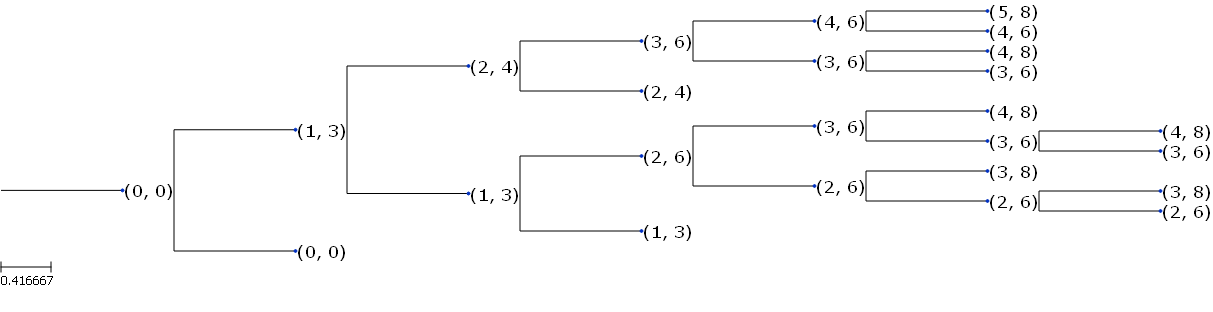

In [134]:
def BBTree2ete(bbtree):
    res_tree = ete3.Tree()
    res_tree.name = bbtree.__repr__()
    bbtree_to_visit = [bbtree]
    ete_to_visit = [res_tree]
    
    while len(bbtree_to_visit) > 0:
        current_bbtree = bbtree_to_visit.pop(0)
        current_ete = ete_to_visit.pop(0)
        
        for bbchild in current_bbtree.children:
            ete_child = ete3.Tree()
            current_ete.add_child(ete_child)
            # Adding name
            ete_child.name = bbchild.__repr__()
            
            # Visit child's children if it's not a leaf
            if len(bbchild.children) > 0:
                bbtree_to_visit.append(bbchild)
                ete_to_visit.append(ete_child)
                
    return res_tree

def plot_BBTree(bbtree):
    
def my_layout(node):
    if node.is_leaf():
         # If terminal node, draws its name
         name_face = AttrFace("name")
    else:
         # If internal node, draws label with smaller font size
         name_face = AttrFace("name", fsize=10)
    # Adds the name face to the image at the preferred position
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")
ts = ete3.TreeStyle()
ts.scale =  120 # 120 pixels per branch length unit
ete_tree = BBTree2ete(root)


ts.show_leaf_name = False
ts.layout_fn = my_layout   

print(ete_tree.get_ascii(show_internal=True))
ete_tree.render("%%inline", tree_style=ts)